In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import MaxNLocator

In [2]:
# smoother
def Jacrelax(level, nx, ny, nz, u, f, iters=1, pre=False):
    dx = 1.0 / nx
    dy = 1.0 / ny
    dz = 1.0 / nz
    Ax = 1.0 / dx**2
    Ay = 1.0 / dy**2
    Az = 1.0 / dz**2
    Ap = 1.0 / (2.0*(1.0/dx**2 + 1.0/dy**2 + 1.0/dz**2))

    # Dirichlet Boundary Conditions
    u[ 0,:,:] = -u[ 1,:,:]
    u[-1,:,:] = -u[-2,:,:]
    u[: ,0,:] = -u[:, 1,:]
    u[:,-1,:] = -u[:,-2,:]
    u[:,:, 0] = -u[:,:, 1]
    u[:,:,-1] = -u[:,:,-2]

    if(pre and level>1):
        u[1:nx+1, 1:ny+1, 1:nz+1] = - Ap*f[1:nx+1, 1:ny+1, 1:nz+1]
        
        # Dirichlet BC
        u[ 0,:,:] = -u[ 1,:,:]
        u[-1,:,:] = -u[-2,:,:]
        u[: ,0,:] = -u[:, 1,:]
        u[:,-1,:] = -u[:,-2,:]
        u[:,:, 0] = -u[:,:, 1]
        u[:,:,-1] = -u[:,:,-2]
        iters -= iters
    
    for _ in range(iters):
        u[1:nx+1, 1:ny+1, 1:nz+1] = Ap*(Ax*(u[2:nx+2, 1:ny+1, 1:nz+1] + u[0:nx, 1:ny+1, 1:nz+1])
                                    + Ay*(u[1:nx+1, 2:ny+2, 1:nz+1] + u[1:nx+1, 0:ny, 1:nz+1])
                                    + Az*(u[1:nx+1, 1:ny+1, 2:nz+2] + u[1:nx+1, 1:ny+1, 0:nz])
                                    - f[1:nx+1, 1:ny+1, 1:nz+1])
        #Dirichlet BC
        u[ 0,:,:] = -u[ 1,:,:]
        u[-1,:,:] = -u[-2,:,:]
        u[: ,0,:] = -u[:, 1,:]
        u[:,-1,:] = -u[:,-2,:]
        u[:,:, 0] = -u[:,:, 1]
        u[:,:,-1] = -u[:,:,-2]
        
  
    res = np.zeros([nx+2, ny+2, nz+2])
    res[1:nx+1,1:ny+1,1:nz+1] = f[1:nx+1, 1:ny+1, 1:nz+1] - (Ax*(u[2:nx+2, 1:ny+1, 1:nz+1] + u[0:nx, 1:ny+1, 1:nz+1])
                                                   + Ay*(u[1:nx+1, 2:ny+2, 1:nz+1] + u[1:nx+1, 0:ny, 1:nz+1])
                                                   + Az*(u[1:nx+1, 1:ny+1, 2:nz+2] + u[1:nx+1, 1:ny+1, 0:nz])
                                                   - 2.0*(Ax+Ay+Az) * u[1:nx+1, 1:ny+1, 1:nx+1])
    
    return u, res

In [3]:
# restriction
def restrict(nx, ny, nz, v):
    v_c = np.zeros([nx+2, ny+2, nz+2])

    v_c[1:nx+1, 1:ny+1, 1:nz+1] = 0.125*(v[1:2*nx:2, 1:2*ny:2, 1:2*nz:2] + v[1:2*nx:2, 2:2*ny+1:2, 1:2*nz:2] 
                                + v[2:2*nx+1:2, 1:2*ny:2, 1:2*nz:2] + v[2:2*nx+1:2, 2:2*ny+1:2, 1:2*nz:2]
                                + v[1:2*nx:2, 1:2*ny:2, 2:2*nz+1:2] + v[1:2*nx:2, 2:2*ny+1:2, 2:2*nz+1:2] 
                                + v[2:2*nx+1:2, 1:2*ny:2, 2:2*nz+1:2] + v[2:2*nx+1:2, 2:2*ny+1:2, 2:2*nz+1:2])
    return v_c

In [4]:
# prolongation
def prolong(nx, ny, nz, v):
    v_f = np.zeros([2*nx+2, 2*ny+2, 2*nz+2])

    a = 27.0/64
    b = 9.0/64
    c = 3.0/64
    d = 1.0/64

    v_f[1:2*nx:2  ,1:2*ny:2  ,1:2*nz:2  ] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[0:nx  ,1:ny+1,1:nz+1] + v[1:nx+1,0:ny  ,1:nz+1] + v[1:nx+1,1:ny+1,0:nz  ]) + c*(v[0:nx  ,0:ny  ,1:nz+1] + v[0:nx  ,1:ny+1,0:nz  ] + v[1:nx+1,0:ny  ,0:nz  ]) + d*v[0:nx  ,0:ny  ,0:nz  ]
    v_f[2:2*nx+1:2,1:2*ny:2  ,1:2*nz:2  ] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[2:nx+2,1:ny+1,1:nz+1] + v[1:nx+1,0:ny  ,1:nz+1] + v[1:nx+1,1:ny+1,0:nz  ]) + c*(v[2:nx+2,0:ny  ,1:nz+1] + v[2:nx+2,1:ny+1,0:nz  ] + v[1:nx+1,0:ny  ,0:nz  ]) + d*v[2:nx+2,0:ny  ,0:nz  ]
    v_f[1:2*nx:2  ,2:2*ny+1:2,1:2*nz:2  ] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[0:nx  ,1:ny+1,1:nz+1] + v[1:nx+1,2:ny+2,1:nz+1] + v[1:nx+1,1:ny+1,0:nz  ]) + c*(v[0:nx  ,2:ny+2,1:nz+1] + v[0:nx  ,1:ny+1,0:nz  ] + v[1:nx+1,2:ny+2,0:nz  ]) + d*v[0:nx  ,2:ny+2,0:nz  ]
    v_f[2:2*nx+1:2,2:2*ny+1:2,1:2*nz:2  ] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[2:nx+2,1:ny+1,1:nz+1] + v[1:nx+1,2:ny+2,1:nz+1] + v[1:nx+1,1:ny+1,0:nz  ]) + c*(v[2:nx+2,2:ny+2,1:nz+1] + v[2:nx+2,1:ny+1,0:nz  ] + v[1:nx+1,2:ny+2,0:nz  ]) + d*v[2:nx+2,2:ny+2,0:nz  ]
    v_f[1:2*nx:2  ,1:2*ny:2  ,2:2*nz+1:2] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[0:nx  ,1:ny+1,1:nz+1] + v[1:nx+1,0:ny  ,1:nz+1] + v[1:nx+1,1:ny+1,2:nz+2]) + c*(v[0:nx  ,0:ny  ,1:nz+1] + v[0:nx  ,1:ny+1,2:nz+2] + v[1:nx+1,0:ny  ,2:nz+2]) + d*v[0:nx  ,0:ny  ,2:nz+2]
    v_f[2:2*nx+1:2,1:2*ny:2  ,2:2*nz+1:2] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[2:nx+2,1:ny+1,1:nz+1] + v[1:nx+1,0:ny  ,1:nz+1] + v[1:nx+1,1:ny+1,2:nz+2]) + c*(v[2:nx+2,0:ny  ,1:nz+1] + v[2:nx+2,1:ny+1,2:nz+2] + v[1:nx+1,0:ny  ,2:nz+2]) + d*v[2:nx+2,0:ny  ,2:nz+2]
    v_f[1:2*nx:2  ,2:2*ny+1:2,2:2*nz+1:2] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[0:nx  ,1:ny+1,1:nz+1] + v[1:nx+1,2:ny+2,1:nz+1] + v[1:nx+1,1:ny+1,2:nz+2]) + c*(v[0:nx  ,2:ny+2,1:nz+1] + v[0:nx  ,1:ny+1,2:nz+2] + v[1:nx+1,2:ny+2,2:nz+2]) + d*v[0:nx  ,2:ny+2,2:nz+2]
    v_f[2:2*nx+1:2,2:2*ny+1:2,2:2*nz+1:2] = a*v[1:nx+1,1:ny+1,1:nz+1] + b*(v[2:nx+2,1:ny+1,1:nz+1] + v[1:nx+1,2:ny+2,1:nz+1] + v[1:nx+1,1:ny+1,2:nz+2]) + c*(v[2:nx+2,2:ny+2,1:nz+1] + v[2:nx+2,1:ny+1,2:nz+2] + v[1:nx+1,2:ny+2,2:nz+2]) + d*v[2:nx+2,2:ny+2,2:nz+2]
    
    return v_f

In [5]:
def V_cycle(nx, ny, nz, num_levels, u, f, level=1):
    # bottom solve
    if level == num_levels:
        u, res = Jacrelax(level, nx, ny, nz, u, f, iters=50)
        return u, res

    # Step 1: smooth Au=f on this grid
    u, res = Jacrelax(level, nx, ny, nz, u, f, iters=1, pre=True)

    # Step 2: Restrict residual to coarse grid
    res_c = restrict(nx//2, ny//2, nz//2, res)

    # Step 3: Solve A e_c=res_c on the coarse grid recursively
    e_c = np.zeros_like(res_c)
    e_c, res_c = V_cycle(nx//2, ny//2, nz//2, num_levels, e_c, res_c, level+1)

    # Step 4: prolong e_c to fine grid and add to u
    u += prolong(nx//2, ny//2, nz//2, e_c)

    # Step 5: smooth Au=f on this grid
    u, res = Jacrelax(level, nx, ny, nz, u, f, iters=1)

    return u, res

In [6]:
# full-cycle
def FMG(nx,ny,nz,num_levels,f,nv=1,level=1):
    # bottom solve
    if level == num_levels:
        u = np.zeros([nx+2, ny+2, nz+2])  
        u, res = Jacrelax(level, nx, ny, nz, u, f, iters=1)
        return u, res

    # Step 1: Restrict the eighthand-side to a coarse grid
    f_c = restrict(nx//2, ny//2, nz//2, f)

    # Step 2: Solve the coarse grid problem using FMG
    u_c, _ = FMG(nx//2, ny//2, nz//2, num_levels, f_c, nv, level+1)

    # Step 3: Interpolate u_c to the fine grid
    u = prolong(nx//2, ny//2, nz//2, u_c)

    # Step 4: Execute 'nv' V-cycles
    for _ in range(nv):
        u, res = V_cycle(nx, ny, nz, num_levels-level, u, f)
        
    return u, res

In [7]:
# analytical solution
def Uann(x, y, z, n):
    return np.sin(2*n*np.pi*x) * np.sin(2*n*np.pi*y) * np.sin(2*n*np.pi*z)

# righthand-side corresponding to above
def source(x, y, z, n):
    return -12 * (np.pi)**2 * n**2 * np.sin(2*n*np.pi*x) * np.sin(2*n*np.pi*y) * np.sin(2*n*np.pi*z)

In [8]:
#input
max_cycles = 20           #maximum number of V cycles
nlevels    = 6            #total number of grid levels. 1 means no multigrid, 2 means one coarse grid. etc 
NX         = 1*2**(nlevels-1) #Nx and Ny are given as function of grid levels
NY         = 1*2**(nlevels-1) 
NZ         = 1*2**(nlevels-1) 
tol        = 1e-7

In [9]:
# the grid has one layer of ghost cells to help apply the boundary conditions
uann = np.zeros([NX+2, NY+2, NZ+2]) #analytical solution
u    = np.zeros([NX+2, NY+2, NZ+2]) #approximation
f    = np.zeros([NX+2, NY+2, NZ+2]) #RHS

# calcualte the RHS and exact solution
DX = 1.0 / NX
DY = 1.0 / NY
DZ = 1.0 / NZ

xc = np.linspace(0.5*DX, 1-0.5*DX, NX)
yc = np.linspace(0.5*DY, 1-0.5*DY, NY)
zc = np.linspace(0.5*DZ, 1-0.5*DZ, NZ)

XX, YY, ZZ = np.meshgrid(xc, yc, zc)

uann[1:NX+1,1:NY+1,1:NZ+1] = Uann  (XX,YY,ZZ,1)
f   [1:NX+1,1:NY+1,1:NZ+1] = source(XX,YY,ZZ,1)

In [10]:
print('mgd3d.py V-cycle solver:')
print('NX:',NX,', NY:',NY,'NZ:',NZ,', tol:',tol,'levels: ',nlevels)
v_err_arr = []

#start solving
tb=time.time()

#V cycle
for it in range(1,max_cycles+1):
    u, res = V_cycle(NX,NY,NZ,nlevels,u,f)
    rtol = np.max(np.max(np.abs(res)))
    
    if rtol < tol:
        break
        
    error = uann[1:NX+1, 1:NY+1, 1:NZ+1] - u[1:NX+1, 1:NY+1, 1:NZ+1]
    en = np.max(np.max(np.abs(error)))
    v_err_arr.append(en)
    print('  cycle: ',it,', L_inf(res.)= ',rtol,',L_inf(true error): ',en)

print('Elapsed time: ',time.time()-tb,' seconds')

mgd3d.py V-cycle solver:
NX: 32 , NY: 32 NZ: 32 , tol: 1e-07 levels:  6
  cycle:  1 , L_inf(res.)=  44.25354363743557 ,L_inf(true error):  0.3566508260279563
  cycle:  2 , L_inf(res.)=  16.795022358528954 ,L_inf(true error):  0.12856808448784585
  cycle:  3 , L_inf(res.)=  6.389823716527175 ,L_inf(true error):  0.045168240468624
  cycle:  4 , L_inf(res.)=  2.4381695278130167 ,L_inf(true error):  0.014590460115323056
  cycle:  5 , L_inf(res.)=  0.9332501654548935 ,L_inf(true error):  0.0033628564354333257
  cycle:  6 , L_inf(res.)=  0.3583876926491314 ,L_inf(true error):  0.0007648835113087671
  cycle:  7 , L_inf(res.)=  0.1380940578124239 ,L_inf(true error):  0.00228434508894515
  cycle:  8 , L_inf(res.)=  0.05339461676842916 ,L_inf(true error):  0.0028444330568773157
  cycle:  9 , L_inf(res.)=  0.02071774251952263 ,L_inf(true error):  0.0030511897469016613
  cycle:  10 , L_inf(res.)=  0.008067148985432482 ,L_inf(true error):  0.003127635493244574
  cycle:  11 , L_inf(res.)=  0.0031523

[]

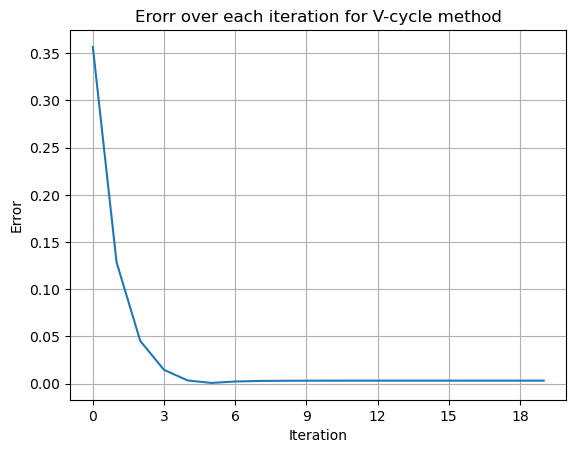

In [11]:
# plot iteration versus error
iterations = np.arange(0, len(v_err_arr))

plt.plot(iterations, v_err_arr)
plt.xlabel("Iteration")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Error")
plt.title("Erorr over each iteration for V-cycle method")
plt.grid()
plt.plot()

In [12]:
print('mgd3d.py FMG solver:')
print('NX:',NX,', NY:',NY,'NZ:',NZ,', tol:',tol,'levels: ',nlevels)

# start solving
tb = time.time()

u,res = FMG(NX,NY,NZ,nlevels,f,2)
print('  Elapsed time: ',time.time()-tb,' seconds')
error = uann[1:NX+1,1:NY+1,1:NZ+1] - u[1:NX+1,1:NY+1,1:NZ+1]
en = np.max(np.max(np.abs(error)))
print('  L_inf(true error): ',en)

mgd3d.py FMG solver:
NX: 32 , NY: 32 NZ: 32 , tol: 1e-07 levels:  6
  Elapsed time:  0.05422067642211914  seconds
  L_inf(true error):  0.007517169715499761
